<a href="https://colab.research.google.com/github/wihasnakerang/DeepL/blob/main/Squeeznet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os, sys
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cv2
import json
# import SqueezeNet

from tensorflow import keras  # Import Keras dari TensorFlow
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, datasets, models, losses, optimizers, metrics, utils, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as tf_ppimg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/semester 7/deepL/dataset_cnn')

In [ ]:
DATADIR = '/content/drive/MyDrive/semester 7/deepL/dataset_cnn'   # base directory
CATEGORIES = ['kupu_hijau_biru', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_jarak', 'kupu_harimau_kuning_hijau', 'kupu_batik_cap', 'kupu_raja_limau', 'kupu_jojo']    # base directory

In [ ]:
def count_images(directory):
    # Pastikan iterasi dilakukan pada subdirektori di folder utama
    for category in os.listdir(directory):
        path = os.path.join(directory, category)
        if os.path.isdir(path):  # Pastikan hanya memproses direktori
            images = os.listdir(path)  # Ambil semua file di subdirektori
            num_images = len(images)  # Hitung jumlah file
            print(f'{category}: {num_images} images')

# Jalankan fungsi untuk menghitung jumlah gambar
count_images('/content/drive/MyDrive/semester 7/deepL/dataset_cnn')

kupu_hijau_biru: 100 images
kupu_pantat_merah: 95 images
kupu_raja_helena: 8 images
kupu_jarak: 7 images
kupu_harimau_kuning_hijau: 100 images
kupu_batik_cap: 100 images
kupu_raja_limau: 100 images
kupu_jojo: 100 images


In [ ]:
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

create_training_data()

In [ ]:
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

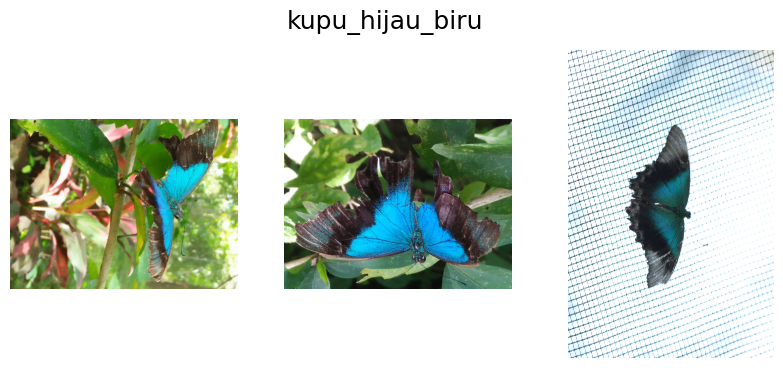

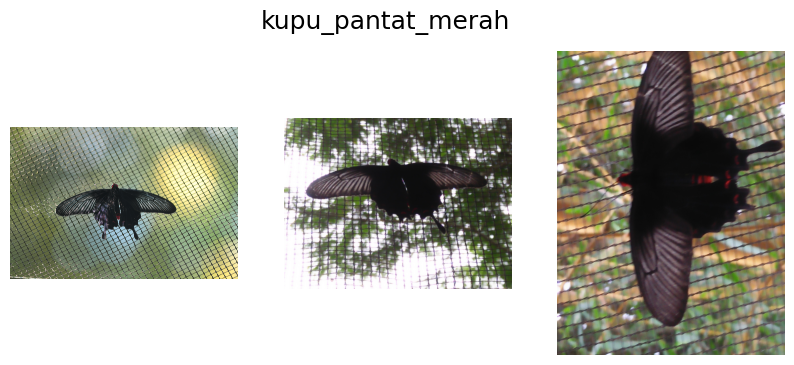

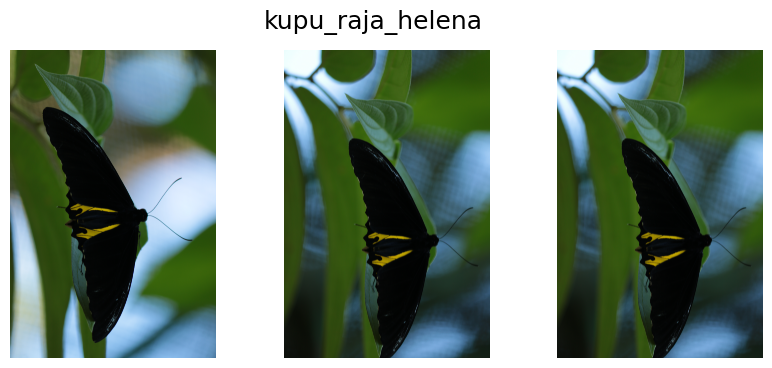

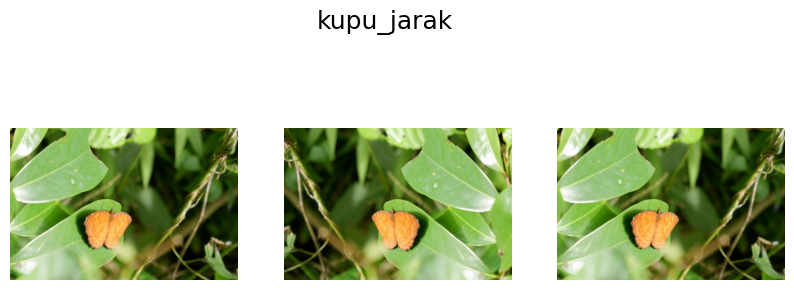

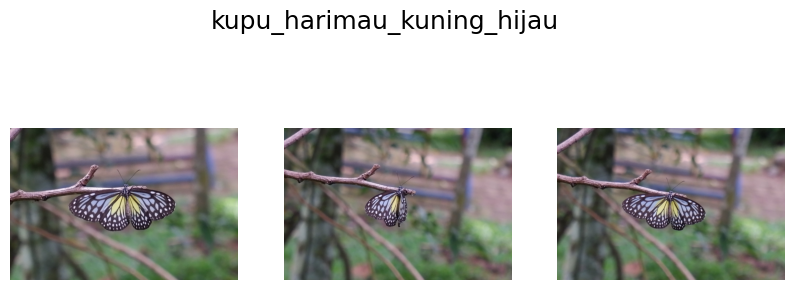

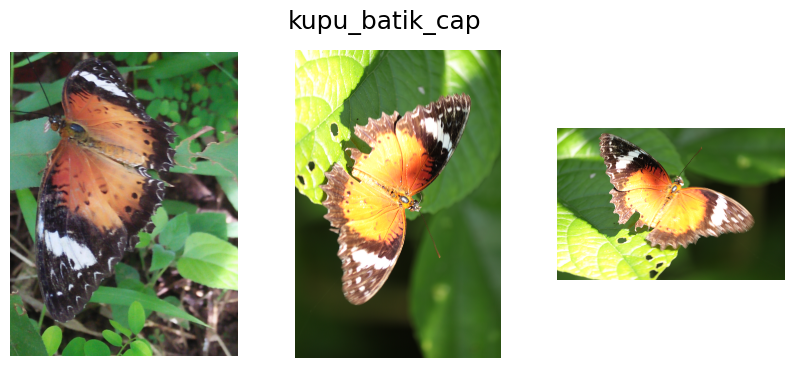

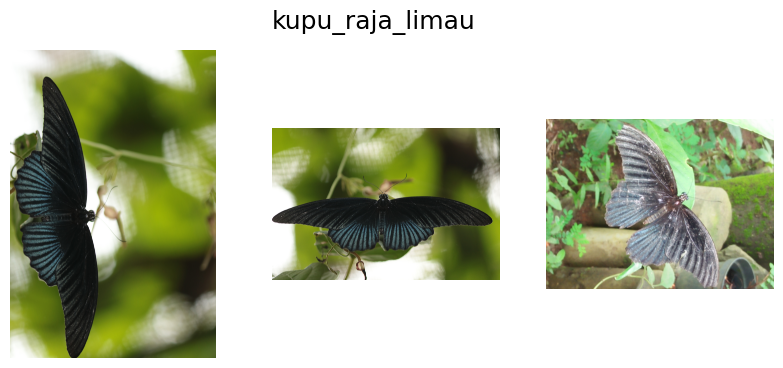

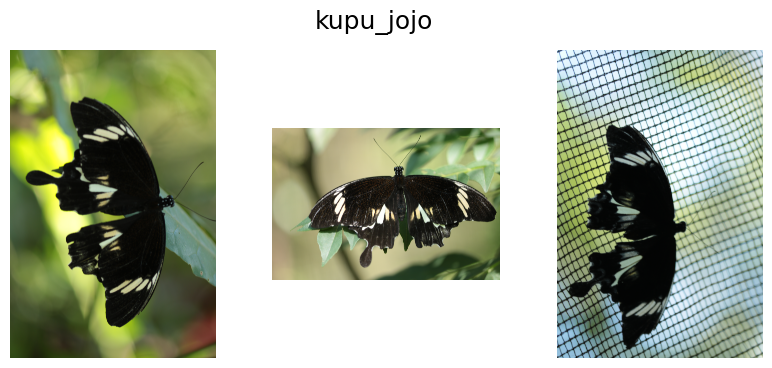

In [ ]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Mengubah y_train dan y_test menjadi format one-hot encoding
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)

In [ ]:
print('Train - Test - Val: images shape:')
for name, data in zip(('X_train', 'y_train', 'X_test', 'y_test'), (X_train, y_train, X_test, y_test)):
    print(f"{name}: {data.shape}")

print(f"Training images: {X_train.shape[0]} images.")
print(f"Testing images: {X_test.shape[0]} images.")

In [ ]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '_'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [ ]:
IN_SHAPE = (32, 32, 3)

In [ ]:
def SqueezeNet(input_shape=IN_SHAPE, classes=7):

    img_input = layers.Input(shape=input_shape)

    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
#     x = layers.Dropout(0.2, name='drop9')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1, name='drop11')(x)

    out = layers.Activation('softmax', name='loss')(x)
    model = models.Model(img_input, out, name='squeezenet')

    return model

In [ ]:
def compile_model(model):
    opt = optimizers.Adam(learning_rate=0.0001)#, momentum=0.9)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
    return model

In [ ]:
sn = compile_model(SqueezeNet())
sn.summary()
# len(sn.layers)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images, labels, label_map):

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

        # Menggunakan np.argmax untuk mendapatkan indeks kelas dari one-hot encoding
        label_index = np.argmax(labels[i])  # Mengambil indeks kelas dari label one-hot encoding
        label_name = list(label_map.keys())[list(label_map.values()).index(label_index)]

        ax.set_title(label_name, fontsize=7)

    plt.show()

print('Training images : ' + str(X_train.shape[0]) + ' images.')
plot_images(X_train[:5], y_train[:5], label_map)

print(20 * '-')

print('Testing images : ' + str(X_test.shape[0]) + ' images.')
plot_images(X_test[:5], y_test[:5], label_map)


In [ ]:
def run_test_harness(model, X_train, y_train, X_test, y_test):

    batch_size = 64

    datagen = tf_ppimg.ImageDataGenerator(validation_split=0.2,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True)

    train_generator = datagen.flow(x=X_train,
                                   y=y_train,
                                   batch_size=batch_size,
                                   seed=39,
                                   shuffle=True,
                                   subset='training')

    val_generator = datagen.flow(X_train,
                                 y_train,
                                 seed=39,
                                 shuffle=True,
                                 batch_size=batch_size,
                                 subset='validation')

    # test datagen
    test_datagen = tf_ppimg.ImageDataGenerator(rescale=1./255)

    # fit model
    steps = train_generator.n//batch_size
    history = model.fit(train_generator,
                        steps_per_epoch=steps,
                        epochs=150,
                        validation_data=val_generator,
                        validation_steps=val_generator.n//batch_size)
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    print('> %.3f' % (acc * 100.0))

    return history

In [ ]:
history = run_test_harness(sn, X_train, y_train, X_test, y_test)

In [ ]:
evaluate = sn.evaluate(X_test, y_test)
print(f'{list(zip(evaluate, sn.metrics_names))}')

In [ ]:
def plot_accuracy_and_loss(history):
    "function reads model's history and plot its train and validation - acc and loss over the run"
    plt.figure(1, figsize= (15, 10))
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show();
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
y_pred = sn.predict(X_test)
y_pred_classes = [np.argmax(el) for el in y_pred]
preds=np.argmax(y_pred, axis=1)
tests=np.argmax(y_test, axis=1)

In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Pastikan jumlah kelas sesuai dengan yang ada dalam dataset
num_classes = 8

# Hitung Classification Report
cr = classification_report(tests, preds, zero_division=1)  # Menggunakan zero_division untuk menangani pembagian dengan nol
print(f'Classification Report:\n {cr}')

# Hitung Confusion Matrix dengan jumlah kelas yang benar
cm = tf.math.confusion_matrix(labels=tests, predictions=preds, num_classes=num_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm.numpy(), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
